In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.mojito2 import explainSamples,aggregateRankings,getMixedTriangles,prepareDataset
from utils.dataset_parser import generateDataset

In [3]:
import pandas as pd
import os
from deeper.DeepER import init_embeddings_index,init_embeddings_model
import numpy as np
from keras.models import load_model

Using TensorFlow backend.


## Wrapper functions

In [13]:
from deeper.data import data2Inputs_unlabeled

In [4]:
# Caricamento strutture dati e modelli ausiliari.
EMBEDDING_FILEPATH ='embeddings/glove.840B.300d.txt'
embeddings_index = init_embeddings_index(EMBEDDING_FILEPATH)
##embeddings_model, tokenizer = init_embeddings_model(embeddings_index)

* Costruzione indice degli embeddings.....Fatto. 2196016 embeddings totali.


In [5]:
embeddings_model, tokenizer = init_embeddings_model(embeddings_index)

* Creazione del modello per il calcolo degli embeddings....
* Inizializzo il tokenizzatore.....Fatto: 1702926 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (1702927, 300)

°°° EMBEDDING MODEL °°°
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    510878100   Tupla_A[0][0]                    
                                         

In [9]:
def dataset_tolist(dataset,lprefix,rprefix,ignore_columns=['label','id']):
    res = []
    attributes = [col for col in dataset.columns if col not in ignore_columns]
    for i in range(len(dataset.index)):
        row = dataset.iloc[i]
        ltuple,rtuple = ([],[])
        for attr in attributes:
            if attr.startswith(lprefix):
                ltuple = ltuple+ str(row[attr]).split()
            else:
                rtuple = rtuple+str(row[attr]).split()
        res.append((ltuple,rtuple))
    return res

In [10]:
def wrap_deeper(dataset,lprefix,rprefix,model,tokenizer,embedding_model,ignore_columns=['label','id']):
    dataset_list = dataset_tolist(dataset,lprefix,rprefix,ignore_columns=ignore_columns)
    ltokens,rtokens = data2Inputs_unlabeled(dataset_list,tokenizer)
    lembeddings,rembeddings = embedding_model.predict([ltokens,rtokens])
    predictions = model.predict([lembeddings,rembeddings])
    return predictions

In [11]:
predict_fn = lambda data,model,ignore: wrap_deeper(data,'ltable_','rtable_',model,tokenizer,embeddings_model,
                                                  ignore_columns=ignore)

## Itunes-Amazon

In [10]:
!cp ../deepmatcher-experiments/datasets/Structured/itunes-amazon/tableA.csv ./
!cp ../deepmatcher-experiments/datasets/Structured/itunes-amazon/tableB.csv ./

In [15]:
itunes_model = load_model('models/DeepER_best_model_100_itunes-amazon.h5')

In [24]:
negrank,_,flipped,notflipped = explainSamples(test,[tableA,tableB],itunes_model,predict_fn,0,1)

100%|██████████| 93/93 [00:12<00:00,  8.49it/s]


In [ ]:
aggregateRankings(negrank,positive=False,

## Walmart-Amazon

In [40]:
augmented_test = pd.read_csv('datasets/walmart_amazon/augmented_test.csv')
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv',dtype=str)
amazon = pd.read_csv('datasets/walmart_amazon/amazon.csv',dtype=str)

In [7]:
walmart_model = load_model('models/DeepER_best_model_100_walmart-amazon.h5')

In [41]:
predictions = predict_fn(augmented_test,walmart_model,['label','id'])
tp_group = augmented_test[(predictions[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions = pd.concat([tp_group,tn_group])
len(correctPredictions)

816

In [42]:
negrank,_,_ = explainSamples(correctPredictions,[walmart,amazon],walmart_model,predict_fn,0,1)

100%|██████████| 521/521 [00:09<00:00, 57.65it/s]


In [43]:
posrank,_,_ = explainSamples(correctPredictions,[walmart,amazon],walmart_model,predict_fn,1,1)

100%|██████████| 521/521 [00:09<00:00, 56.52it/s]


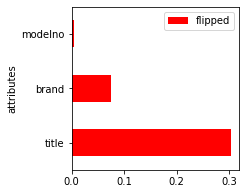

In [45]:
ax,rank = aggregateRankings(negrank,positive=False,maxLenAttributes=1,lenTriangles=521)

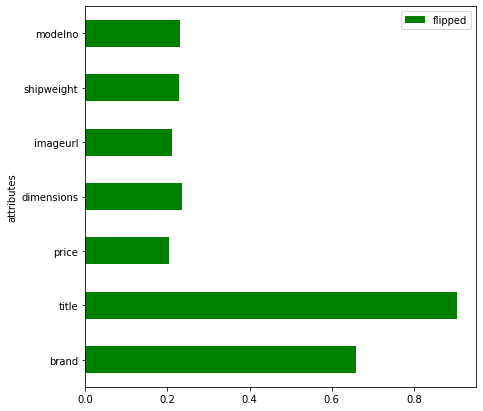

In [46]:
ax,rank = aggregateRankings(posrank,positive=True,maxLenAttributes=1,lenTriangles=521)

## Amazon-Google

In [47]:
augmented_test = pd.read_csv('datasets/Amazon-GoogleProducts/augmented_test.csv')

In [48]:
amazongoogle_mod = load_model('models/DeepER_best_model_100_amazon-google.h5')

In [49]:
predictions = predict_fn(augmented_test,amazongoogle_mod,['label','id'])
tp_group = augmented_test[(predictions[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions = pd.concat([tp_group,tn_group])
len(correctPredictions)

567

In [50]:
amazon = pd.read_csv('datasets/Amazon-GoogleProducts/Amazon.csv',dtype=str)
google = pd.read_csv('datasets/Amazon-GoogleProducts/Google.csv',dtype=str)

In [51]:
negrank,_,_ = explainSamples(correctPredictions,[amazon,google],amazongoogle_mod,predict_fn,0,1)

100%|██████████| 183/183 [00:12<00:00, 14.86it/s]


In [52]:
posrank,_,_ = explainSamples(correctPredictions,[amazon,google],amazongoogle_mod,predict_fn,1,1)

100%|██████████| 183/183 [00:12<00:00, 14.84it/s]


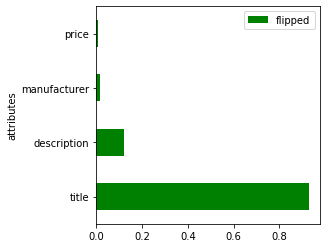

In [53]:
ax,rank = aggregateRankings(posrank,positive=True,maxLenAttributes=1,lenTriangles=182)

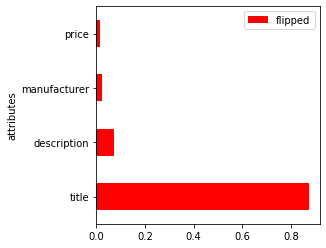

In [54]:
ax,negrank = aggregateRankings(negrank,positive=False,maxLenAttributes=1,lenTriangles=182)

## Fodors-Zagats

In [17]:
fodors_model = load_model('models/DeepER_best_model_100_fodors-zagats.h5')


In [26]:
augmented_test = pd.read_csv('datasets/fodors_zagats/augmented_test.csv')

In [27]:
predictions = predict_fn(augmented_test,fodors_model,['label','id'])
tp_group = augmented_test[(predictions[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions = pd.concat([tp_group,tn_group])
len(correctPredictions),len(augmented_test)

(63, 139)

In [21]:
fodors = pd.read_csv('datasets/fodors_zagats/fodors.csv',dtype=str)
zagats = pd.read_csv('datasets/fodors_zagats/zagats.csv',dtype=str)

In [22]:
negrank,_,_ = explainSamples(correctPredictions,[fodors,zagats],fodors_model,predict_fn,0,1)

100%|██████████| 11/11 [00:00<00:00, 47.01it/s]


In [23]:
posrank,_,_ = explainSamples(correctPredictions,[fodors,zagats],fodors_model,predict_fn,1,1)

100%|██████████| 11/11 [00:00<00:00, 47.66it/s]
